In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

#from sklearn import preprocessing as pp
#from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import re
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

#import torchvision.transforms as transforms
import torch.optim as optimizers
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import WeightedRandomSampler, BatchSampler

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed: int = 123):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
    
set_seed(123)

In [4]:
train_new = pd.read_csv('../input/intern-compe/train_added_encoded.csv')
test_new = pd.read_csv('../input/intern-compe/test_added_encoded.csv')
all_data = pd.read_csv('../input/intern-compe/all_added_encoded.csv')

In [5]:
target_cols = ["state"]
#feature_cols = ["country", "duration", "category1", "category2", "goal_min", "goal_max"]
#categorical_cols = ["country", "category1", "category2"]
feature_cols = ["duration", "category1", "category2", "goal_min"]
categorical_cols = ["category1", "category2"]

In [6]:
class CFDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.csv_file = csv_file
        self.transform = transform
        self.feature_cols = ["duration", "category1", "category2", "goal_min"]
        self.target_cols = ["state"]
        
        
    def __len__(self):
        return len(self.csv_file)
    
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        features = self.csv_file[self.feature_cols].iloc[idx]
        features = torch.FloatTensor(features)
        try:
            target = self.csv_file[self.target_cols].iloc[idx]
            target = torch.Tensor(target)
            # train_step
        except:
            target = self.csv_file["id"].iloc[idx]
            # test_step
        
        if self.transform:
            features = self.transform(features)
            
        return features, target

In [7]:
class CFDataModule(pl.LightningDataModule):
    def __init__(self, csv_file, transform, split_rate, batch_size, num_workers):
        super().__init__()
        self.csv_file = csv_file
        self.transform = transform
        self.split_rate = split_rate
        self.batch_size = batch_size
        self.num_workers = num_workers
        

    def setup(self, stage=None):
        dataset = self.csv_file
        n_samples = len(dataset)
        n_train = int(n_samples * 0.8)
        n_val = n_samples - n_train
        train_dataset, val_dataset = train_test_split(dataset,  train_size=n_train, test_size=n_val)
        
        self.train_dataset = CFDataset(csv_file=train_dataset, transform=self.transform)
        self.val_dataset = CFDataset(csv_file=val_dataset, transform=self.transform)
        
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset,
                          batch_size=self.batch_size,
                          drop_last=True,
                          num_workers=self.num_workers,
                          pin_memory=True)
    
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset,
                          batch_size=self.batch_size,
                          drop_last=True,
                          num_workers=self.num_workers,
                          pin_memory=True)

In [8]:
class CFModule(pl.LightningModule):
    def __init__(self, num_features, hidden_size, dropout, num_classes):
        super(CFModule, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(dropout*(2/5))
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size*2))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size*2)
        self.dropout2 = nn.Dropout(dropout)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size*2, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout)
        self.layer4 = nn.Linear(hidden_size, num_classes)
        
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.relu(self.dense3(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.layer4(x)
        
        x = torch.sigmoid(x)
        
        return x
    
    
    def training_step(self, batch, batch_idx):
        x, t = batch
        pred = self.forward(x)
        loss = self.criterion(pred, t)
        #acc = self.metric(pred, t)
        # you should define log as {"tag_name/log_name"}
        tensorboard_logs = {'train/train_loss': loss}
        return {"loss": loss, "logs": tensorboard_logs, "progress_bar": tensorboard_logs}
    
    
    def validation_step(self, batch, batch_idx):
        x, t = batch
        pred = self.forward(x)
        loss = self.criterion(pred, t)
        #acc = self.metric(pred, t)
        logs = {"val_loss": loss}
        return {"val_loss": loss, "progress_bar": logs}

    
    def validation_end(self, outputs):
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        #avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        tensorboard_logs = {'val/avg_loss': avg_loss}
        # you should call back as name "val_loss" to using the Early-Stopping
        return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
    
    def test_step(self, batch, batch_idx):
        x, t = batch
        ids = t
        preds = self.forward(x)
        #self.preds.extend(preds.tolist())
        #self.ids.extend(ids.tolist())
        return {"ids": ids, "preds": preds}
        
        
    def test_step_end(self, outputs):
        ids = outputs["ids"]
        preds = outputs["preds"]
        ids_sub = ids_sub.extend(ids.tolist())
        preds_sub = preds_sub.extend(preds.tolist())
    
    
    def configure_optimizers(self):
        optimizer = optimizers.Adam(self.parameters(), 
                                    lr=0.001, betas=(0.9,0.999),
                                    eps=1e-08, weight_decay=0, amsgrad=False)
        scheduler = {"scheduler": 
                     optimizers.lr_scheduler.CosineAnnealingLR(
                        optimizer, T_max=10),
                    "interval": "epoch",
                    "monitor": "val_loss"}
        return [optimizer], [scheduler]
    
    
    def criterion(self, pred, t):
        return F.mse_loss(input=pred, target=t)

In [9]:
class CFModel(nn.Module):
    def __init__(self, num_features, hidden_size, dropout, num_classes):
        super().__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(dropout*(2/5))
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size*2))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size*2)
        self.dropout2 = nn.Dropout(dropout)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size*2, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(dropout)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm4 = nn.BatchNorm1d(hidden_size)
        self.dropout4 = nn.Dropout(dropout)
        self.layer4 = nn.Linear(hidden_size, num_classes)
        
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = F.relu(self.dense3(x))
        
        x = self.batch_norm4(x)
        x = self.dropout4(x)
        x = self.layer4(x)
        
        x = torch.sigmoid(x)
        
        return x

In [10]:
def make_submission(model, data_loader):
    preds = torch.tensor([])
    ids = []
    target_columns = "state"
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    preds = preds.to(device)
    model.to(device)
    model.eval()
    for x, t in tqdm(data_loader):
        x = x.to(device)
        x = model(x)
        preds = torch.cat((preds, x), dim=0)
        ids += list(map(int, t.to("cpu")))
        
    preds = torch.squeeze(preds)
    preds = preds.tolist()
    prediction_df = pd.DataFrame({"ids": ids, "preds": preds})
    return prediction_df

In [11]:
# test phase

def main():
    
    batch_size=256*4
    num_workers = 4
    
    # model config
    num_input = len(feature_cols)
    hidden_size = num_input*2
    dropout = 0.3
    num_classes = 1
    
    PATH = "../input/cf-ver3/epoch8.ckpt"
    check_point = torch.load(PATH)

    model = CFModel(num_features=num_input, hidden_size=hidden_size, dropout=dropout, num_classes=num_classes)
    model.load_state_dict(check_point["state_dict"])
    
    test_dataset = CFDataset(test_new)
    test_dataloader = DataLoader(test_dataset,
                          batch_size=batch_size,
                          drop_last=False,
                          num_workers=num_workers,
                          pin_memory=True)
    
    submission_df = make_submission(model, test_dataloader)
    return submission_df

In [12]:
submission_df = main()
submission_df

100%|██████████| 11/11 [00:11<00:00,  1.00s/it]


,ids,preds
0,10545,0.384323
1,10546,0.565546
2,10547,0.365035
3,10548,0.505474
4,10549,0.331879
...,...,...
10539,21084,0.547159
10540,21085,0.561219
10541,21086,0.556377
10542,21087,0.535386


In [13]:
def postprocess(sub_df, threshold):
    df = sub_df.copy()
    preds = np.array(df["preds"])
    df["preds"] = np.where(preds<threshold, 0, 1)
    return df

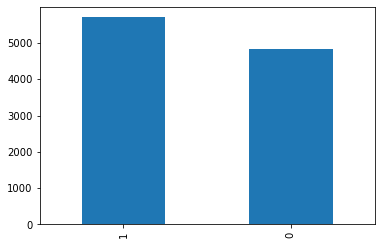

In [14]:
sub = postprocess(submission_df, 0.54)
plt.figure()
sub["preds"].value_counts().plot(kind="bar")

In [15]:
submission_df.to_csv('submission.csv', index=False, header=False)